# Tablesaw 

[Tablesaw](https://tablesaw.tech/) provides the ability to easily transform, summarize, and filter data, as well as computing descriptive statistics. It can also be used easily with libraries like Smile, which provides fundamental machine learning algorithms.

This notebook has some basic demos of how to use Tablesaw, including visualizing the results for which it uses the BeakerX interactive visualization APIs. Tablesaw also provides its own visualization APIs if you wish to do visualization outside of BeakerX. The notebook covers basic table manipulation, k-means clustering, linear regression, and fetching financial data.

In [ ]:
addDependency("tech.tablesaw:tablesaw-core:0.43.1");
addDependency("eu.hansolo.fx:charts:17.1.51");
addDependency("com.github.haifengl:smile-core:2.0.0");

In [ ]:
import static tech.tablesaw.aggregate.AggregateFunctions.*;
import tech.tablesaw.api.*;
import tech.tablesaw.columns.*;

// javafx imports
import javafx.scene.paint.Color;
import javafx.geometry.Orientation;

// chart imports
import eu.hansolo.fx.charts.ChartType;
import eu.hansolo.fx.charts.Position;
import eu.hansolo.fx.charts.XYChart;
import eu.hansolo.fx.charts.XYPane;
import eu.hansolo.fx.charts.data.XYChartItem;
import eu.hansolo.fx.charts.tools.Helper;
import eu.hansolo.fx.charts.series.XYSeriesBuilder;


In [ ]:
var tornadoes = Table.read().csv("../examples/jtablesaw/resources/tornadoes_2014.csv");

In [ ]:
tornadoes.structure()

In [ ]:
//get header names
tornadoes.columnNames()

In [ ]:
//displays the row and column counts
tornadoes.shape()

In [ ]:
//displays the first n rows
tornadoes.first(10)

In [ ]:
tornadoes.structure()

In [ ]:
//summarize the data in each column
tornadoes.summary()

In [ ]:
//Mapping operations
var month = tornadoes.dateColumn("Date").month();
tornadoes.addColumns(month);
tornadoes.columnNames();

In [ ]:
//Sorting by column
tornadoes.sortOn("-Fatalities")

In [ ]:
//Descriptive statistics
tornadoes.column("Fatalities").summary()

In [ ]:
//Performing totals and sub-totals
var injuriesByScale = tornadoes.summarize("Injuries", median).by("Scale");
injuriesByScale.setName("Median injuries by Tornado Scale");
injuriesByScale

In [ ]:
//Cross Tabs
tornadoes.xTabCounts("State", "Scale")

## K-means clustering

K-means is the most common form of “centroid” clustering. Unlike classification, clustering is an unsupervised learning method. The categories are not predetermined. Instead, the goal is to search for natural groupings in the dataset, such that the members of each group are similar to each other and different from the members of the other groups. The K represents the number of groups to find.

We’ll use a well known Scotch Whiskey dataset, which is used to cluster whiskeys according to their taste based on data collected from tasting notes. As always, we start by loading data and printing its structure.

In [ ]:
import smile.clustering.*;
import smile.data.formula.Formula;
import smile.regression.*;

import java.util.stream.IntStream;
import java.util.Arrays;

In [ ]:
var whiskeyData = Table.read().csv("../examples/jtablesaw/resources/whiskey.csv");
whiskeyData.structure();

In [ ]:
var kMeans = KMeans.fit(whiskeyData.as().doubleMatrix("Body", "Sweetness", "Smoky", "Medicinal", "Tobacco", "Honey", "Spicy", "Winey", "Nutty", "Malty", "Fruity", "Floral"), 5);

In [ ]:
var whiskeyClusters = Table.create("Clusters", whiskeyData.stringColumn("Distillery"), DoubleColumn.create("Cluster", kMeans.y));
whiskeyClusters = whiskeyClusters.sortAscendingOn("Cluster", "Distillery");

## Play (Money)ball with Linear Regression

In baseball, you make the playoffs by winning more games than your rivals. The number of games the rivals win is out of your control so the A’s looked instead at how many wins it took historically to make the playoffs. They decided that 95 wins would give them a strong chance.  Here’s how we might check that assumption in Tablesaw.

In [ ]:
var baseball = Table.read().csv("../examples/jtablesaw/resources/baseball.csv");

// filter to the data available at the start of the 2002 season
var moneyball = baseball.where(baseball.numberColumn("year").isLessThan(2002));
var wins = moneyball.nCol("W");
var year = moneyball.nCol("Year");
var playoffs = moneyball.column("Playoffs");
var runDifference = moneyball.numberColumn("RS").subtract(moneyball.numberColumn("RA")).setName("RD");
moneyball.addColumns(runDifference);

var x = moneyball.numberColumn("RD").asDoubleArray();
var y = moneyball.numberColumn("W").asDoubleArray();
var xMin = Arrays.stream(x).min().getAsDouble();
var xMax = Arrays.stream(x).max().getAsDouble();
var yMin = Arrays.stream(y).min().getAsDouble();
var yMax = Arrays.stream(y).max().getAsDouble();

// ScatterChart
var AXIS_WIDTH     = 25d;
var data = IntStream.range(0,Math.min(x.length, y.length)).mapToObj(i -> new XYChartItem(x[i], y[i])).toList();
var series = XYSeriesBuilder.create()
                                   .items(data)
                                   .chartType(ChartType.SCATTER)
                                   .fill(Color.TRANSPARENT)
                                   .stroke(Color.MAGENTA)
                                   .symbolFill(Color.RED)
                                   .symbolStroke(Color.TRANSPARENT)
                                   .symbolsVisible(true)
                                   .build();
var scatterChartXAxisBottom = Helper.createAxis(xMin, xMax, true, AXIS_WIDTH, Orientation.HORIZONTAL, Position.BOTTOM);
var scatterChartXAxisTop = Helper.createAxis(xMin, xMax, true, AXIS_WIDTH, Orientation.HORIZONTAL, Position.TOP);
var scatterChartXAxisCenter = Helper.createCenterXAxis(xMin, xMax, true, AXIS_WIDTH);
var scatterChartYAxisLeft   = Helper.createAxis(yMin, yMax, true, AXIS_WIDTH, Orientation.VERTICAL, Position.LEFT);
var scatterChartYAxisCenter = Helper.createCenterYAxis(yMin, yMax, true, AXIS_WIDTH);
var scatterChart            = new XYChart<>(new XYPane(series), scatterChartYAxisCenter, scatterChartXAxisTop, scatterChartXAxisBottom);
scatterChartXAxisCenter.setAxisColor(Color.CRIMSON);
scatterChartXAxisTop.setAxisColor(Color.CRIMSON);
scatterChartXAxisBottom.setAxisColor(Color.CRIMSON);
scatterChartYAxisCenter.setAxisColor(Color.CRIMSON);

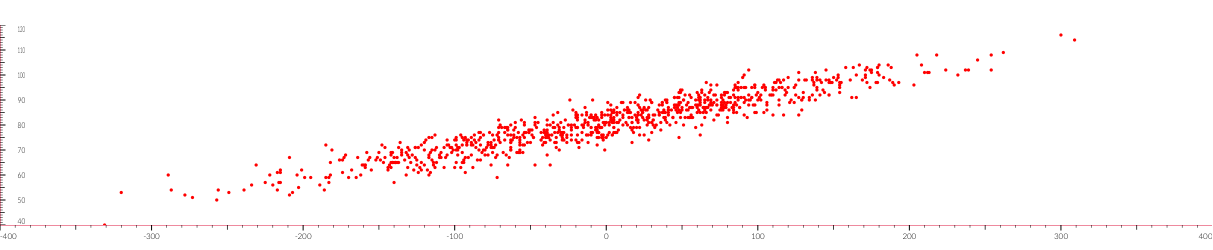

In [ ]:
display(scatterChart);

In [ ]:
var winsModel = OLS.fit(Formula.lhs("RD"), moneyball.select("W", "RD").smile().toDataFrame());

In [ ]:
var runsScored = OLS.fit(Formula.lhs("RS"), moneyball.select("OBP", "SLG", "RS").smile().toDataFrame());

In [ ]:
new Histogram(xLabel:"X",
              yLabel:"Proportion",
              data: Arrays.asList(runsScored.residuals()),
              binCount: 25);

## Financial and Economic Data

You can fetch data from [Quandl](https://www.quandl.com/) and load it directly into Tablesaw

In [ ]:
addDependency("com.jimmoores:quandl-tablesaw:2.1.0");

In [ ]:
import com.jimmoores.quandl.DataSetRequest;
import com.jimmoores.quandl.tablesaw.*;

In [ ]:
var session = TableSawQuandlSession.create();
var table = session.getDataSet(DataSetRequest.Builder.of("WIKI/AAPL").build());
table

In [ ]:
// Create a new column containing the year
var yearColumn = table.dateColumn("Date").year();
yearColumn.setName("Year");
table.addColumns(yearColumn);
// Create max, min and total volume tables aggregated by year
var summaryMax = table.summarize("Adj. Close", max).by("year");
var summaryMin = table.summarize("Adj. Close", min).by("year");
var summaryVolume = table.summarize("Volume", sum).by("year");
// Create a new table from each of these
var summary = Table.create("Summary", summaryMax.column(0), summaryMax.column(1), 
                       summaryMin.column(1), summaryVolume.column(1));
// Add back a DateColumn to the summary...will be used for plotting
var yearDates = DateColumn.create("YearDate");
for (var year : summary.column("Year")) {
    yearDates.append(java.time.LocalDate.of((int) year, 1, 1));
}
summary.addColumns(yearDates);

summary

In [ ]:
var years = summary.column('YearDate').collect()

plot = new TimePlot(title: 'Price Chart for AAPL', xLabel: 'Time', yLabel: 'Max [Adj. Close]')
plot << new YAxis(label: 'Volume')
plot << new Points(x: years, y: summary.column('Max [Adj. Close]').collect())
plot << new Line(x: years, y: summary.column('Max [Adj. Close]').collect(), color: Color.blue)
plot << new Stems(x: years, y: summary.column('Sum [Volume]').collect(), yAxis: 'Volume')